In [1]:
import math
import numpy as np
import torch
from torch import nn

from shiba import Trainer
from shiba.steps import rnn_step, rnn_eval_step
from shiba.callbacks import LambdaCallback, TensorBoard, Metric, Save
from shiba.utils import model_summary

from data import Corpus, LMLoader
from model import LSTMLM

## Load and Tokenize Data

In [2]:
%time corpus = Corpus(path='data/wikitext-2/')

CPU times: user 37.3 s, sys: 192 ms, total: 37.5 s
Wall time: 40.3 s


In [3]:
train_data = corpus.train
valid_data = corpus.valid
test_data = corpus.test
i2w = corpus.dictionary.idx2word

## Set Hyperparams

In [4]:
vocab_size = len(corpus.dictionary) # num unique tokens in dictionary, 33278
batch_size = 32
eval_batch_size = 12
seq_len = 35 # sometimes called back prop through time (bptt) length during training.
variable_length = True

In [5]:
train_loader = LMLoader(train_data, batch_size=batch_size, seq_len=seq_len, variable_length=variable_length)
valid_loader = LMLoader(valid_data, batch_size=eval_batch_size, seq_len=seq_len, variable_length=variable_length)
test_data = LMLoader(test_data, batch_size=eval_batch_size, seq_len=seq_len, variable_length=variable_length)

## Example Sequence

In [6]:
inputs, targets = next(train_loader)
np.array([i2w[i] for i in inputs[:, 10]])

array(['(', '<unk>', ')', '.', 'The', 'partnership', 'for', 'the',
       'Europa', 'Jupiter', 'System', 'Mission', 'has', 'since', 'ended',
       ',', 'but', 'NASA', 'will', 'continue', 'to', 'contribute', 'the',
       'European', 'mission', 'with', 'hardware'], dtype='<U11')

## Define Model

In [7]:
model = LSTMLM(vocab_size=vocab_size, embedding_size=10, hidden_size=20, nlayers=2, dropout=0.5)
hidden = model.init_hidden(batch_size)

## count parameters

In [8]:
model_summary(model, inputs, hidden)

| Name    | Output Size             | Parameters   |
|:--------|:------------------------|:-------------|
| drop    | (27, 32, 20)            | 0            |
| encoder | (27, 32, 10)            | 332,780      |
| lstm    | [(32, 20), (2, 32, 20)] | 5,920        |
| decoder | (864, 33278)            | 698,838      |
| TOTAL:  | -----------------       | 1,037,538    |

## Trainer

In [9]:
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion, train_step=rnn_step, eval_step=rnn_eval_step)

## callbacks

In [10]:
def clip_grad_norm(state, max_norm=0.25):
    model = state.core.model
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def perpexity(loss):
    # exp of cross entropy loss
    return math.exp(loss)
    
callbacks = [TensorBoard(log_dir='runs/shiba-test-lm'),
             Metric('perpexity', 
                    score_func=perpexity,
                    transform=lambda x: x['loss'].item()),
             Save('weights/test-lm', monitor='val_perpexity'),
#              LambdaCallback(on_batch_end=clip_grad_norm)
            ]
!rm -rf ../runs/shiba-test-lm # clear tb logs

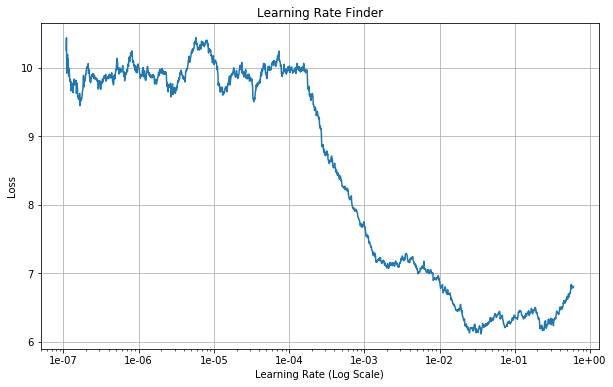

In [11]:
trainer.find_lr(train_loader)

In [12]:
trainer.fit_one_cycle(train_loader, valid_loader, epochs=4, max_lr=5e-2, callbacks=callbacks)